In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  # Example model
from sklearn.linear_model import LogisticRegression  # Example model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Example model
from sklearn.naive_bayes import GaussianNB  # Example model
from sklearn.neural_network import MLPClassifier  # Example model
from sklearn.tree import DecisionTreeClassifier  # Example model
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
import seaborn as sns



In [2]:
# Load the dataset without setting headers, if already done
data = pd.read_excel('default of credit card clients.xls')  # Or use pd.read_csv() for CSV files

# Step 1: Set the first row as column names
data.columns = data.iloc[0]  # Set the first row as the header

data = data[1:]  # Drop the first row

# Reset the index
data.reset_index(drop=True, inplace=True)

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# Step 1: Convert object types to numeric
numeric_columns = [
    'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]


for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, coerce errors to NaN
    
    

# Step 2: Convert target variable to integer
data['default payment next month'] = data['default payment next month'].astype(int)


# Step 3: Handle missing values (if any)
data.fillna(data.mean(), inplace=True)  # Fill NaNs in numeric columns with the mean



# Step 4: One-Hot Encode Categorical Variables
# Convert 'SEX', 'EDUCATION', 'MARRIAGE' to categorical
data['SEX'] = data['SEX'].astype('category')
data['EDUCATION'] = data['EDUCATION'].astype('category')
data['MARRIAGE'] = data['MARRIAGE'].astype('category')



# Perform one-hot encoding
data = pd.get_dummies(data, drop_first=True)

feature_names = data.columns[:-1]  # Assuming the last column is the target variable


# Step 5: Separate Features and Target Variable
X = data.drop('default payment next month', axis=1)  # Features
y = data['default payment next month']  # Target variable



# Step 6: Split the Dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Further split the training set into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)


/tmp/ipykernel_853/986756240.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(data.mean(), inplace=True)  # Fill NaNs in numeric columns with the mean


In [5]:
# --- Aggregating features ---
# Create a new DataFrame for aggregated variables
agg_data = pd.DataFrame()

# Aggregating Payment History (PAY_0 to PAY_6)
agg_data['Mean_Payment_Status'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)
agg_data['Worst_Payment_Status'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].max(axis=1)
agg_data['Count_Late_Payments'] = X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].gt(0).sum(axis=1)

# Aggregating Bill Statement Amount (BILL_AMT1 to BILL_AMT6)
agg_data['Mean_Bill_Amount'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
agg_data['Max_Bill_Amount'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].max(axis=1)
agg_data['Total_Bill_Amount'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)
agg_data['Std_Bill_Amount'] = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].std(axis=1)

# Aggregating Previous Payment Amounts (PAY_AMT1 to PAY_AMT6)
agg_data['Mean_Payment_Amount'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
agg_data['Max_Payment_Amount'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].max(axis=1)
agg_data['Total_Payment_Amount'] = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)

# Adding Payment to Bill Ratio
agg_data['Payment_Bill_Ratio'] = agg_data['Total_Payment_Amount'] / agg_data['Total_Bill_Amount']

# Adding Age and Limit Balance
agg_data['AGE'] = X_train['AGE']
agg_data['LIMIT_BAL'] = X_train['LIMIT_BAL']

# Adding categorical variables (check for one-hot encoded versions)
if 'SEX_1' in X_train.columns:  # Check if male is present (1)
    agg_data['SEX'] = X_train['SEX_1']
if 'EDUCATION_1' in X_train.columns:  # Check for education level (one-hot)
    agg_data['EDUCATION'] = X_train['EDUCATION_1']
if 'MARRIAGE_1' in X_train.columns:  # Check for marriage status (one-hot)
    agg_data['MARRIAGE'] = X_train['MARRIAGE_1']

# Adding target variable for easier correlation analysis later
agg_data['Target'] = y_train.reset_index(drop=True)

# Print aggregated data to confirm inclusion
print(agg_data.head())


      Mean_Payment_Status  Worst_Payment_Status  Count_Late_Payments  \
9922             1.000000                   2.0                    3   
2156             0.000000                   0.0                    0   
162             -0.833333                   0.0                    0   
1463            -0.500000                   0.0                    0   
5624             0.000000                   0.0                    0   

      Mean_Bill_Amount  Max_Bill_Amount  Total_Bill_Amount  Std_Bill_Amount  \
9922      50787.667969          60482.0           304726.0     10378.924805   
2156     271269.500000         305823.0          1627617.0     34254.039062   
162         606.166687           1234.0             3637.0       344.896759   
1463      75681.164062         117497.0           454087.0     54153.761719   
5624     150371.671875         206409.0           902230.0     56212.511719   

      Mean_Payment_Amount  Max_Payment_Amount  Total_Payment_Amount  \
9922          1600.00

In [6]:
agg_data.head()

,Mean_Payment_Status,Worst_Payment_Status,Count_Late_Payments,Mean_Bill_Amount,Max_Bill_Amount,Total_Bill_Amount,Std_Bill_Amount,Mean_Payment_Amount,Max_Payment_Amount,Total_Payment_Amount,Payment_Bill_Ratio,AGE,LIMIT_BAL,EDUCATION,MARRIAGE,Target
9922,1.000000,2.0,3,50787.667969,60482.0,304726.0,10378.924805,1600.000000,2700.0,9600.0,0.031504,38.0,60000.0,1.0,1.0,0.0
2156,0.000000,0.0,0,271269.500000,305823.0,1627617.0,34254.039062,13612.833008,23333.0,81677.0,0.050182,25.0,290000.0,1.0,0.0,0.0
162,-0.833333,0.0,0,606.166687,1234.0,3637.0,344.896759,396.000000,792.0,2376.0,0.653286,47.0,290000.0,0.0,1.0,0.0
1463,-0.500000,0.0,0,75681.164062,117497.0,454087.0,54153.761719,24641.000000,121715.0,147846.0,0.325590,50.0,300000.0,0.0,1.0,0.0
5624,0.000000,0.0,0,150371.671875,206409.0,902230.0,56212.511719,6385.166504,11538.0,38311.0,0.042463,33.0,210000.0,0.0,1.0,0.0


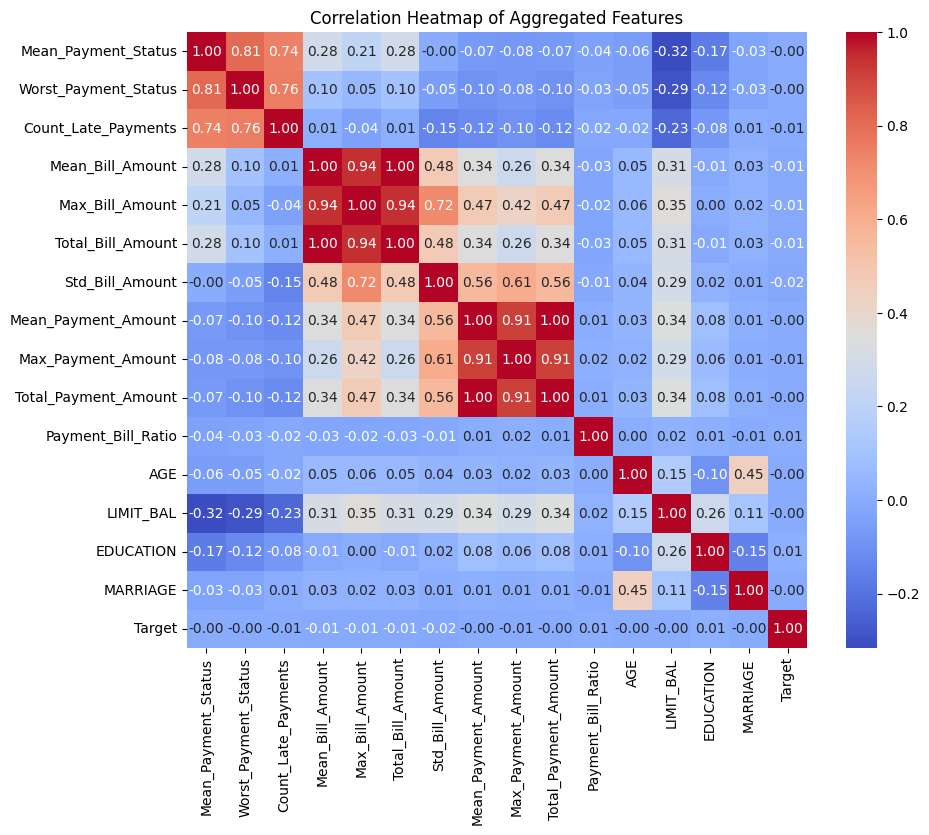

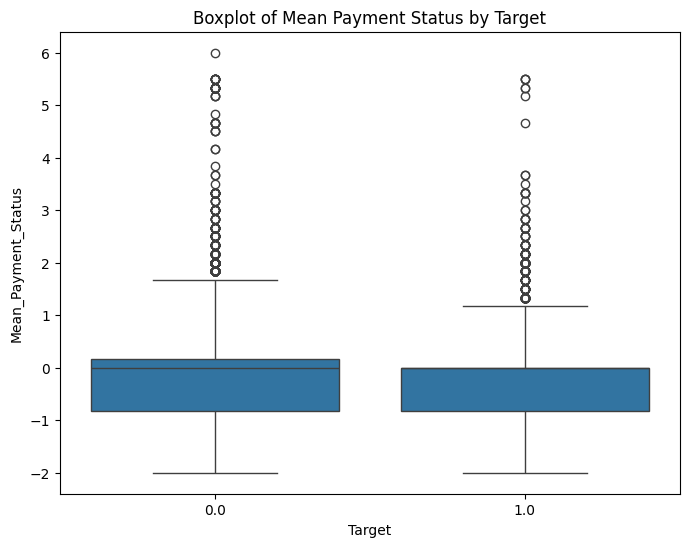

In [7]:
# Step 7: Visual analysis (e.g., plotting the distributions, correlations, etc.)
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Correlation heatmap for the aggregated features
plt.figure(figsize=(10, 8))
sns.heatmap(agg_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Aggregated Features')
plt.show()

# Example: Boxplot for Mean_Payment_Status by target variable
plt.figure(figsize=(8, 6))
sns.boxplot(x='Target', y='Mean_Payment_Status', data=agg_data)
plt.title('Boxplot of Mean Payment Status by Target')
plt.show()

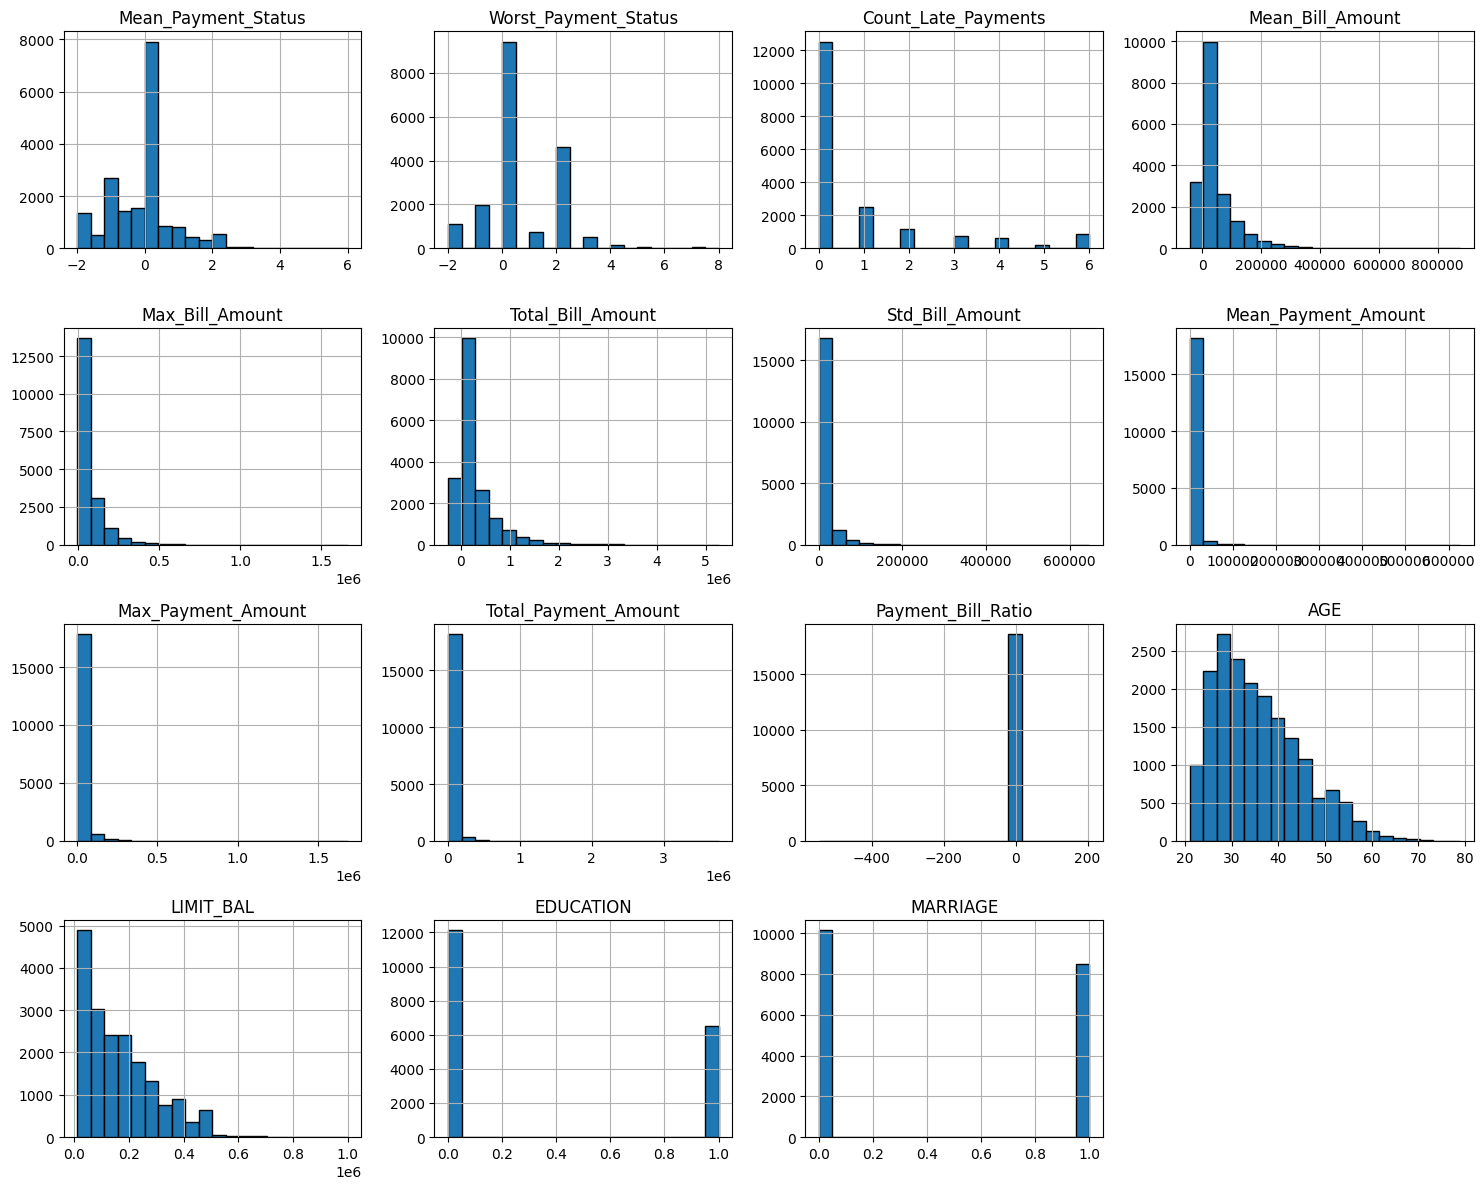

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

# 1. Plot Feature Distributions (Histogram)
def plot_feature_distributions(df):
    # Replace infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Handle missing values (drop or fill NaNs, for this we drop rows with NaN values)
    df = df.dropna()

    # Plot the histograms
    df.hist(figsize=(15, 12), bins=20, edgecolor='black')
    plt.tight_layout()
    plt.show()

# Example: Visualize all aggregated features
plot_feature_distributions(agg_data.drop('Target', axis=1))  # Exclude the target for histogram



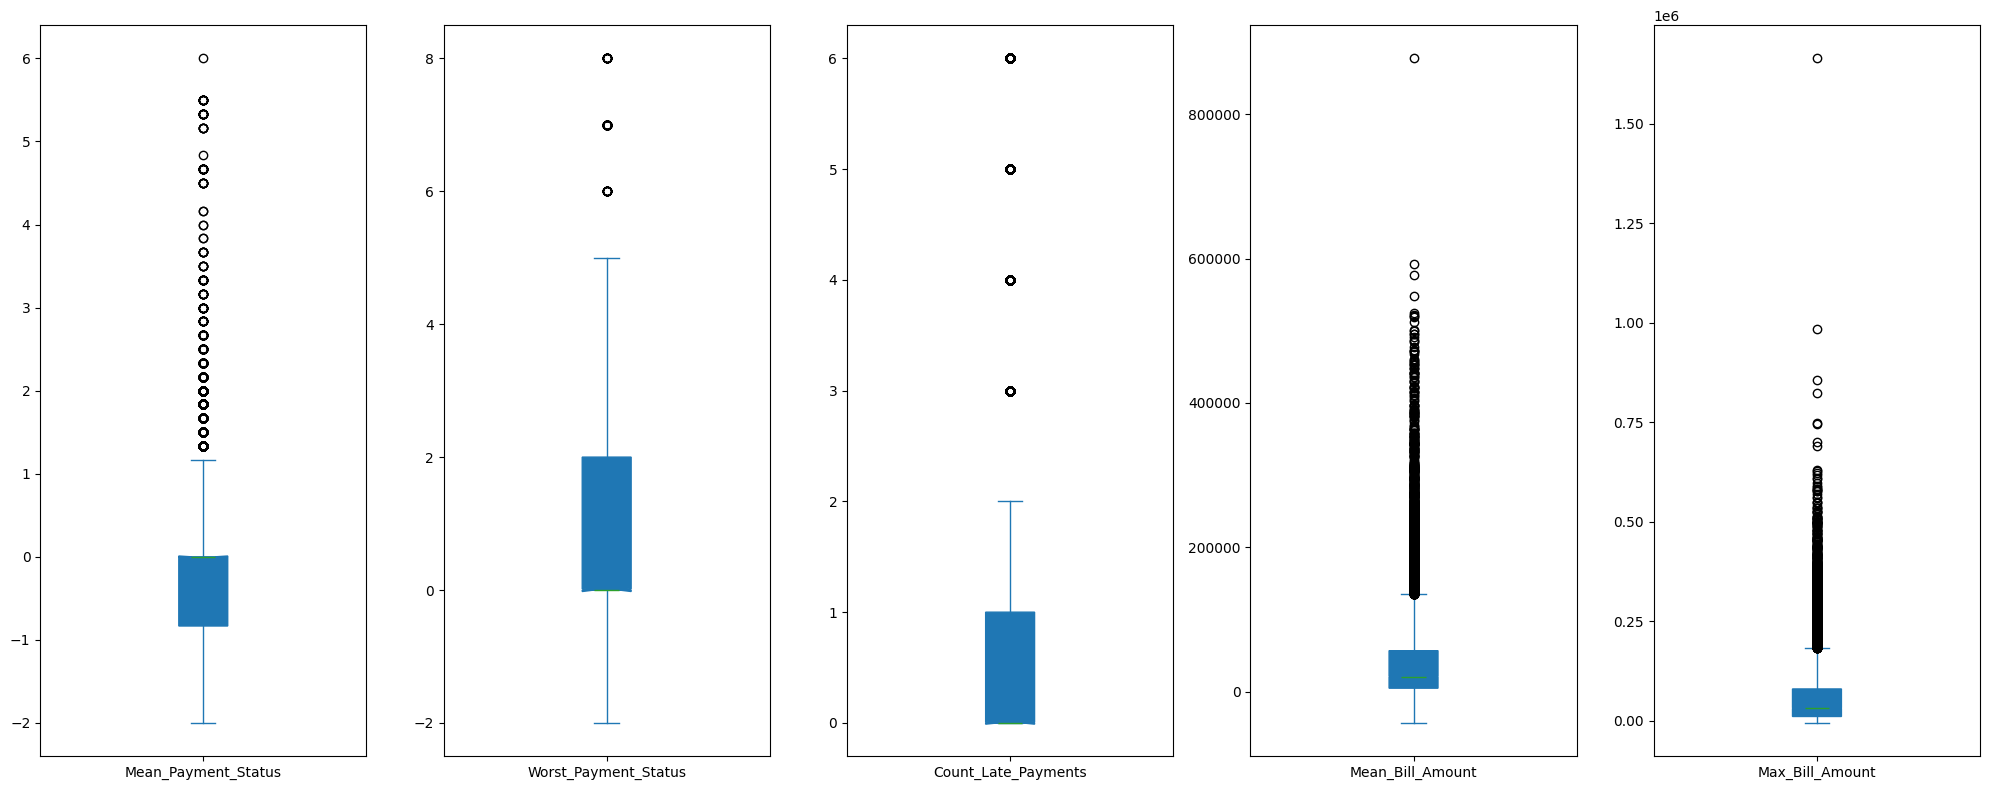

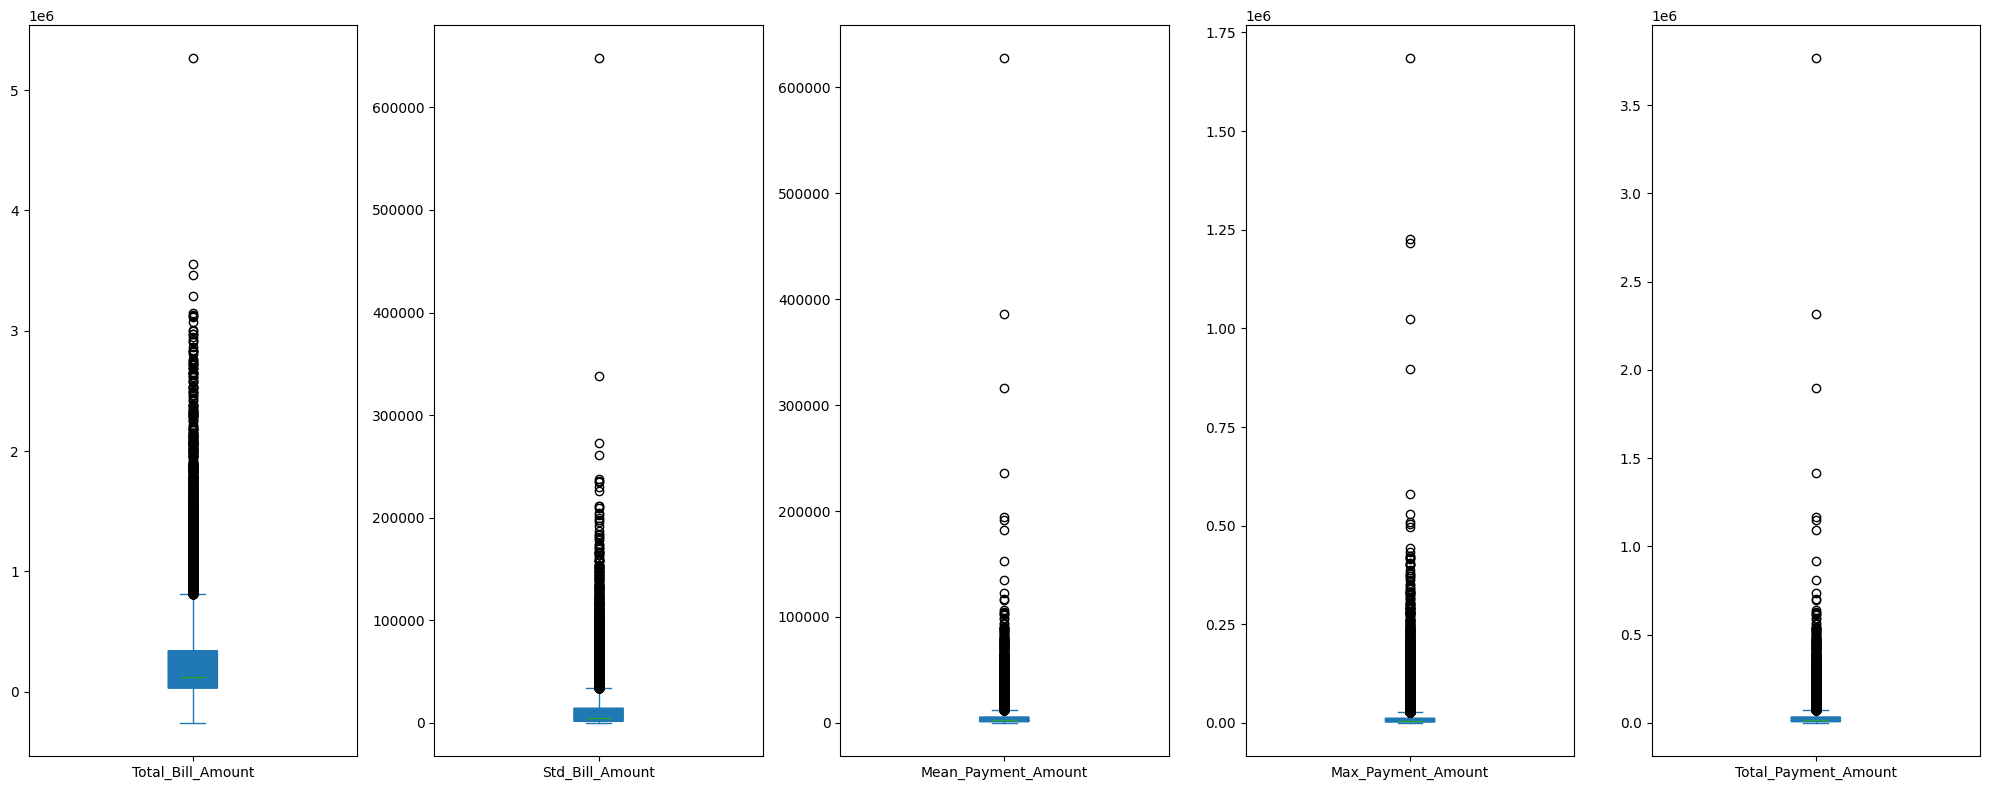

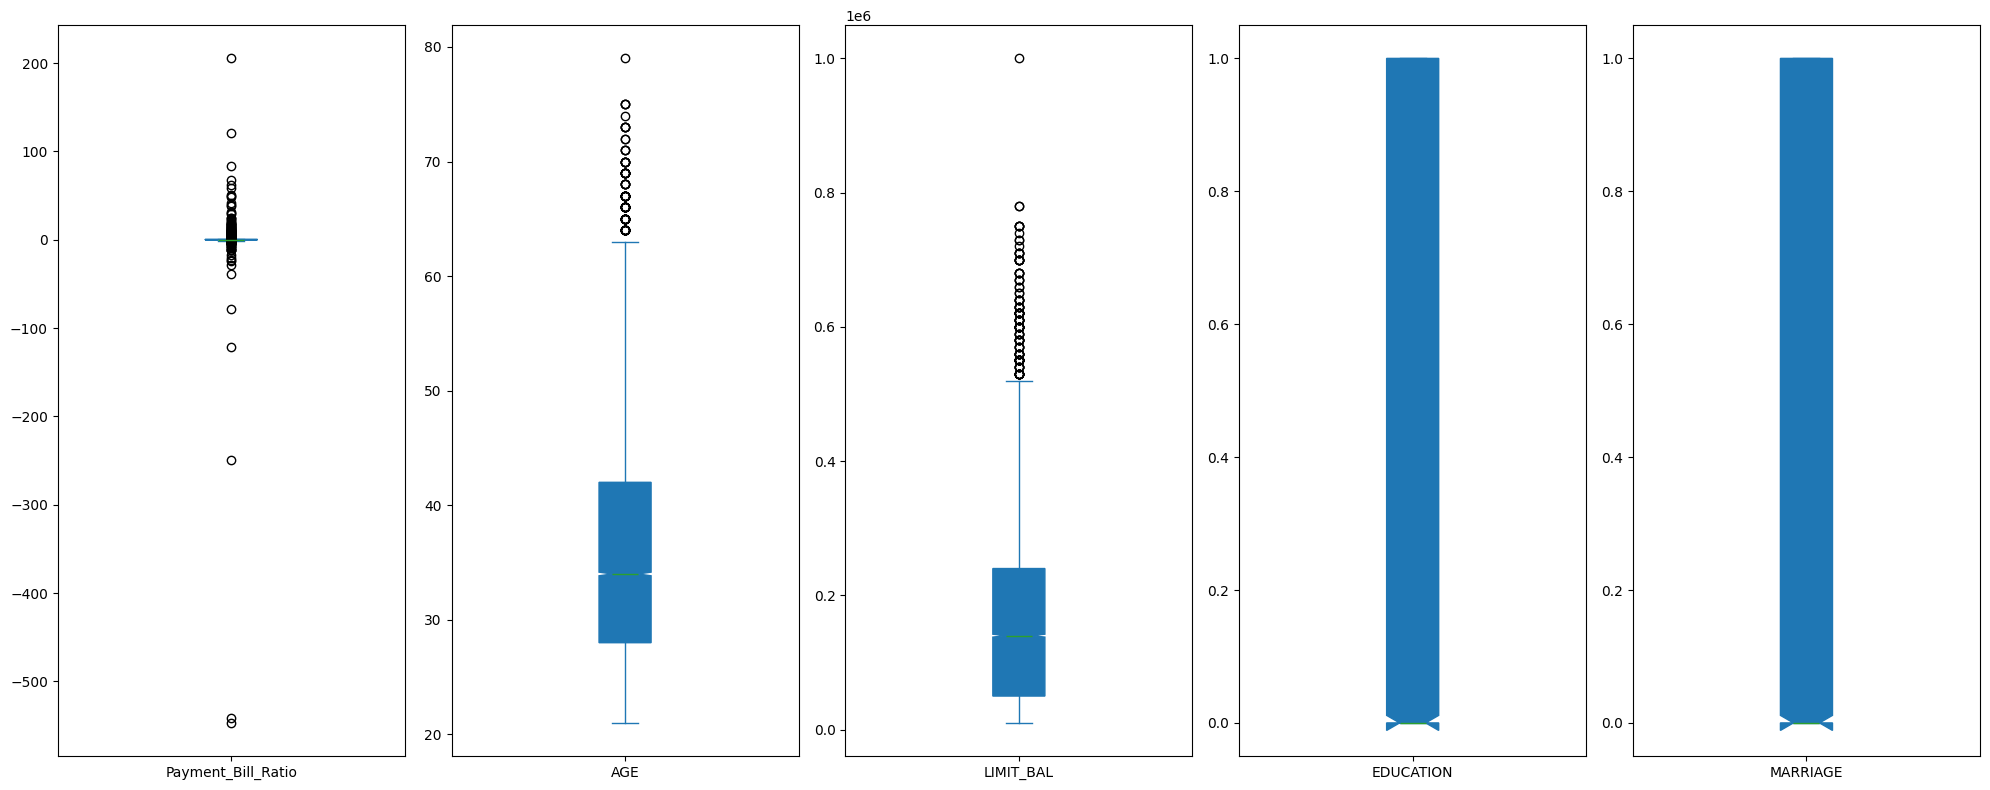

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Plot Boxplots for Feature Distributions in Groups
def plot_feature_boxplots(df, group_size=5):
    # Get the list of feature names
    feature_columns = df.columns
    
    # Split the features into groups of 'group_size'
    for i in range(0, len(feature_columns), group_size):
        group = feature_columns[i:i + group_size]
        
        # Plot boxplots for this group of features
        df[group].plot(kind='box', subplots=True, layout=(1, len(group)), figsize=(20, 8), patch_artist=True, notch=True)
        plt.tight_layout()
        plt.show()

# Example: Boxplots for feature distributions (grouped by 5 features per plot)
plot_feature_boxplots(agg_data.drop('Target', axis=1), group_size=5)  # Exclude the target for boxplots



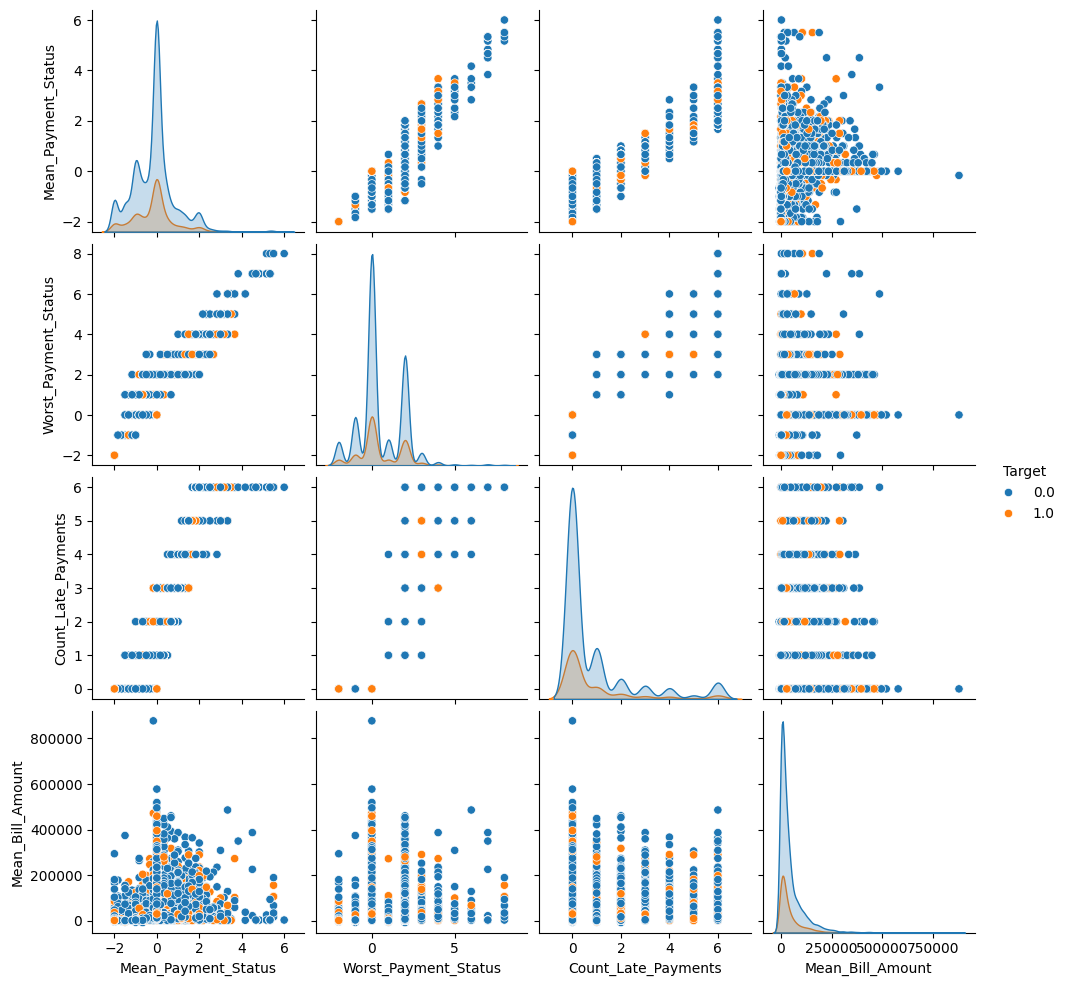

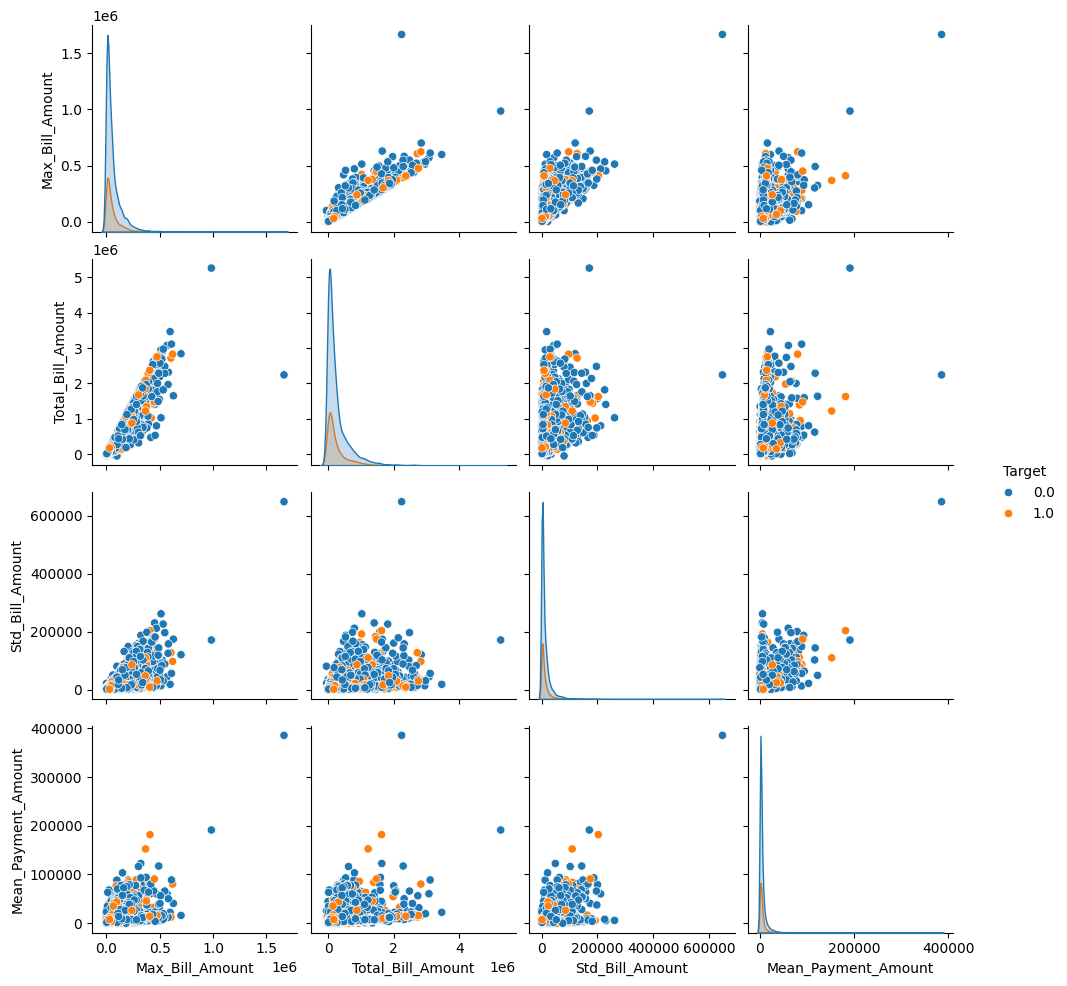

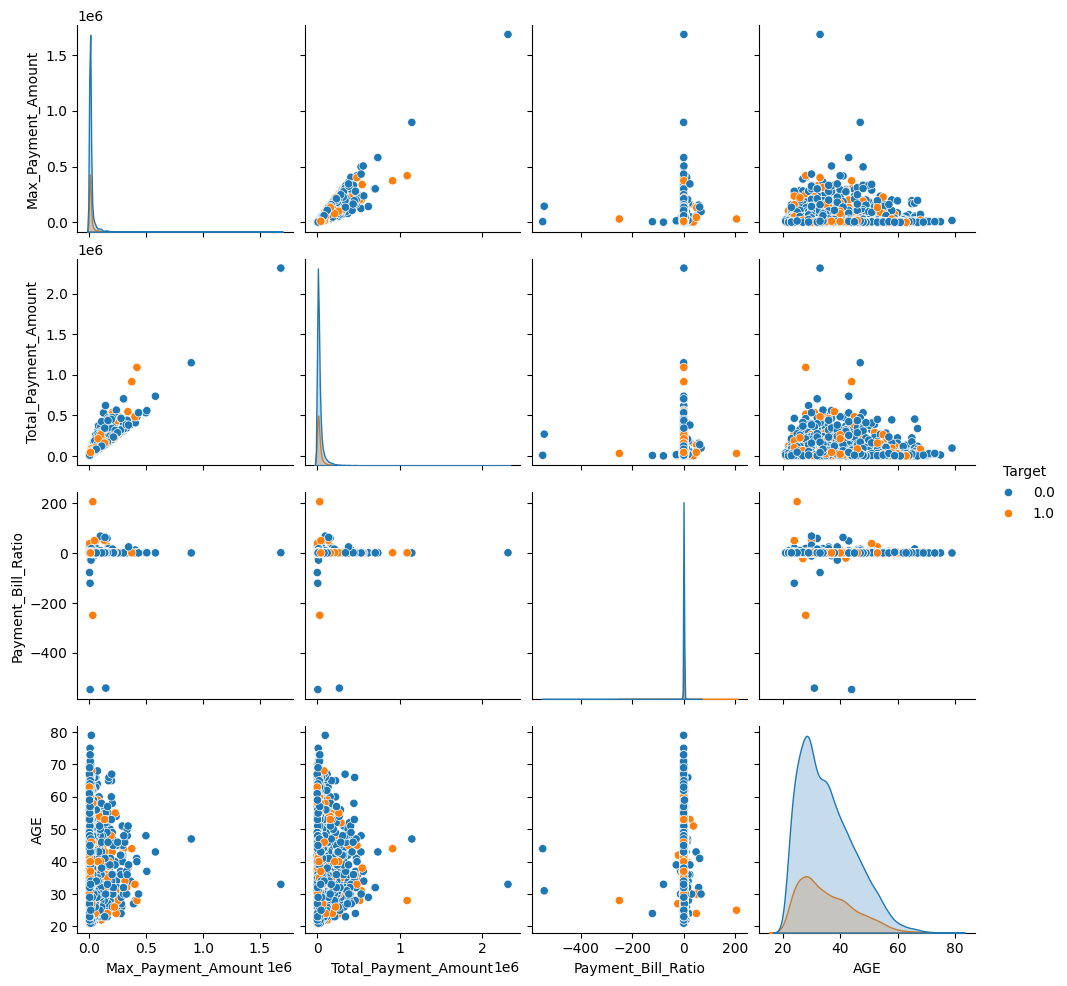

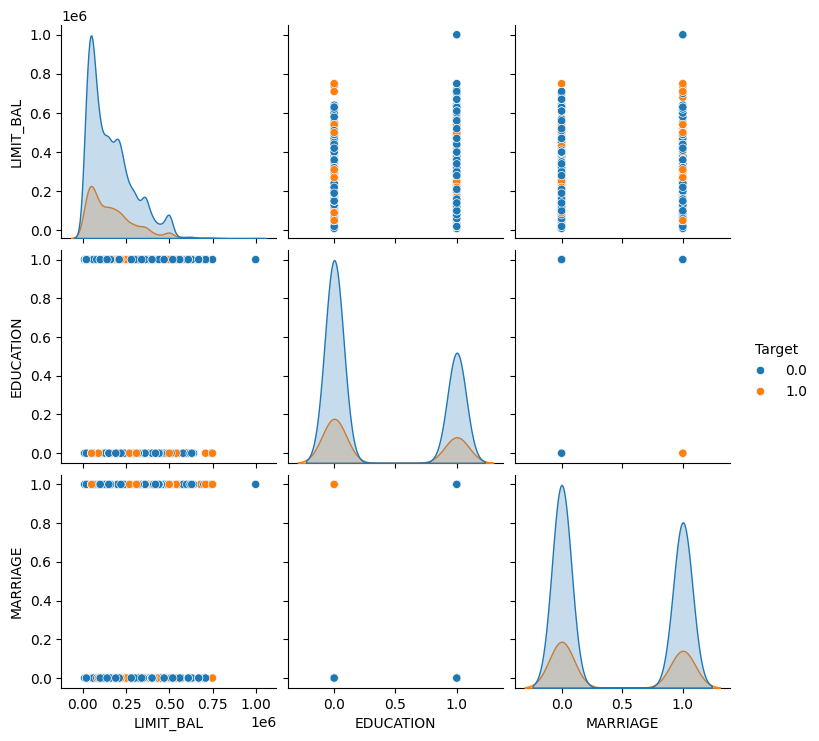

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Plot Pairplot of Features vs Target in Groups
def plot_pairplot(df, target_col, group_size=4):
    # Get the list of feature names (excluding the target column)
    feature_columns = df.columns[df.columns != target_col]  # Exclude target column
    
    # Split the features into groups of 'group_size'
    for i in range(0, len(feature_columns), group_size):
        group = feature_columns[i:i + group_size]
        
        # Create a new DataFrame for the current group of features plus the target
        subset_df = df[list(group) + [target_col]]  # Ensure proper indexing
        
        # Plot pairplot for this group of features and the target
        sns.pairplot(subset_df, hue=target_col, diag_kind='kde')
        plt.show()

# Example: Pairplot between aggregated features and target (grouped by 4 features per plot)
plot_pairplot(agg_data, 'Target', group_size=4)  # You can adjust group_size as needed


In [11]:
#doesnt show much interesting
"""
# 4. Plot Boxplots of Features vs Target Variable
def plot_feature_vs_target(df, target_col):
    for feature in df.drop(target_col, axis=1).columns:  # Exclude the target column from looping
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=target_col, y=feature, data=df)
        plt.title(f'{feature} vs {target_col}')
        plt.show()

# Example: Feature vs Target boxplots
plot_feature_vs_target(agg_data, 'Target')
"""


"\n# 4. Plot Boxplots of Features vs Target Variable\ndef plot_feature_vs_target(df, target_col):\n    for feature in df.drop(target_col, axis=1).columns:  # Exclude the target column from looping\n        plt.figure(figsize=(8, 6))\n        sns.boxplot(x=target_col, y=feature, data=df)\n        plt.title(f'{feature} vs {target_col}')\n        plt.show()\n\n# Example: Feature vs Target boxplots\nplot_feature_vs_target(agg_data, 'Target')\n"

In [12]:
"""
# 5. Plot Distribution of the Target Variable
def plot_target_distribution(y):
    sns.countplot(y)
    plt.title('Target Variable Distribution')
    plt.show()

# Example: Distribution of target variable
plot_target_distribution(agg_data['Target'])
"""

"\n# 5. Plot Distribution of the Target Variable\ndef plot_target_distribution(y):\n    sns.countplot(y)\n    plt.title('Target Variable Distribution')\n    plt.show()\n\n# Example: Distribution of target variable\nplot_target_distribution(agg_data['Target'])\n"

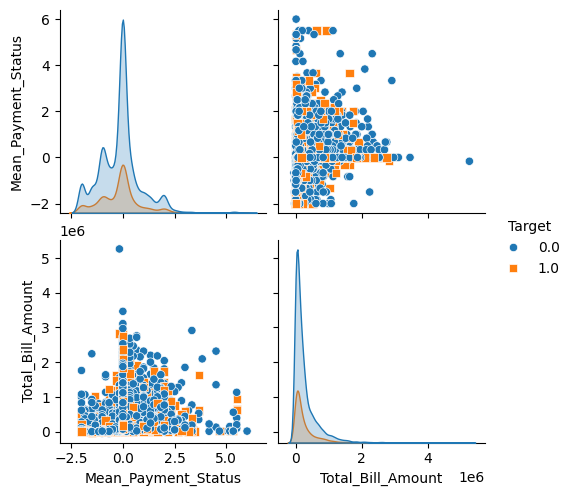

In [13]:
# 6. Plot Scatter Plots for Important Features
def plot_scatter_plots(df, target_col):
    sns.pairplot(df, hue=target_col, markers=["o", "s"])
    plt.show()

# Example: Scatter plots of important features
# Select a few important features to plot
plot_scatter_plots(agg_data[['Mean_Payment_Status', 'Total_Bill_Amount', 'Target']], 'Target')


In [14]:
"""
# 7. Outlier Detection
def plot_outliers(df):
    z_scores = zscore(df)
    abs_z_scores = np.abs(z_scores)
    outliers = (abs_z_scores > 3).any(axis=1)
    print(f'Number of outliers: {sum(outliers)}')
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title('Outliers Detection')
    plt.show()

# Example: Detect outliers in the aggregated data
plot_outliers(agg_data.drop('Target', axis=1))  # Exclude target for outlier detection
"""

"\n# 7. Outlier Detection\ndef plot_outliers(df):\n    z_scores = zscore(df)\n    abs_z_scores = np.abs(z_scores)\n    outliers = (abs_z_scores > 3).any(axis=1)\n    print(f'Number of outliers: {sum(outliers)}')\n    plt.figure(figsize=(10, 6))\n    sns.boxplot(data=df)\n    plt.title('Outliers Detection')\n    plt.show()\n\n# Example: Detect outliers in the aggregated data\nplot_outliers(agg_data.drop('Target', axis=1))  # Exclude target for outlier detection\n"

In [15]:


# Optionally scale the features if needed for certain algorithms
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Apply the same transformation (scaling) to the validation and test sets
X_val_scaled = scaler.transform(X_val)  # Use the same scaler for validation
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test

# Display the shapes of the training and testing sets
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)


Training set shape: (19200, 31) Test set shape: (6000, 31)


In [16]:


# Set up the parameter grid for n_neighbors
knn_params = {'n_neighbors': [3, 5, 7, 9]}  # You can add more values if needed

# Initialize the GridSearchCV with 5-fold cross-validation
grid_search_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy')

# Fit on the training data
grid_search_knn.fit(X_train_scaled, y_train)

# Get the best parameters and model
best_knn = grid_search_knn.best_estimator_

# Predictions using the best model
y_pred_knn = best_knn.predict(X_test_scaled)

# Evaluation
print("Best KNN Parameters:", grid_search_knn.best_params_)
print("KNN Classifier Report:\n", classification_report(y_test, y_pred_knn))



Best KNN Parameters: {'n_neighbors': 9}
KNN Classifier Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88      4687
           1       0.61      0.31      0.41      1313

    accuracy                           0.81      6000
   macro avg       0.72      0.63      0.65      6000
weighted avg       0.78      0.81      0.78      6000



In [17]:
# Initialize Logistic Regression model
logreg = LogisticRegression(class_weight='balanced',max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predictions
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluation
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_logreg))



Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78      4687
           1       0.38      0.63      0.48      1313

    accuracy                           0.69      6000
   macro avg       0.63      0.67      0.63      6000
weighted avg       0.77      0.69      0.72      6000



In [18]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)

print("LDA Report:\n", classification_report(y_test, y_pred_lda))


LDA Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4687
           1       0.69      0.26      0.37      1313

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.63      6000
weighted avg       0.79      0.81      0.78      6000



In [19]:
# Initialize Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

# Evaluation
print("Naive Bayes Report:\n", classification_report(y_test, y_pred_gnb))


Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.88      0.24      0.38      4687
           1       0.25      0.88      0.39      1313

    accuracy                           0.38      6000
   macro avg       0.56      0.56      0.38      6000
weighted avg       0.74      0.38      0.38      6000



In [20]:
# Initialize ANN model

ann = Sequential()

# Input Layer with Batch Normalization
ann.add(Dense(units=32, input_dim=X_train_scaled.shape[1]))
ann.add(BatchNormalization())  # Batch Normalization
ann.add(Dense(units=32, activation='relu'))

# First Hidden Layer with Dropout
ann.add(Dense(units=16, activation='relu'))
ann.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second Hidden Layer with Batch Normalization and Dropout
ann.add(Dense(units=16))
ann.add(BatchNormalization())  # Batch Normalization before activation
ann.add(Dense(units=16, activation='relu'))
ann.add(Dropout(0.3))  # Dropout with a different rate

# Output Layer
ann.add(Dense(units=1, activation='sigmoid'))  # Binary classification output

# Compile the model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
ann.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=1)

# Predictions
y_pred_ann = (ann.predict(X_test_scaled) > 0.5).astype(int)

# Evaluation
print("ANN Report:\n", classification_report(y_test, y_pred_ann))

/home/jovyan/ml/noku-ml/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7300 - loss: 0.5653 - val_accuracy: 0.8048 - val_loss: 0.4605
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8069 - loss: 0.4755 - val_accuracy: 0.8083 - val_loss: 0.4539
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8041 - loss: 0.4683 - val_accuracy: 0.8094 - val_loss: 0.4499
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8072 - loss: 0.4569 - val_accuracy: 0.8081 - val_loss: 0.4506
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8084 - loss: 0.4536 - val_accuracy: 0.8054 - val_loss: 0.4471
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8142 - loss: 0.4478 - val_accuracy: 0.8110 - val_loss: 0.4477
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8154 - loss: 0.4425 - val_accuracy: 0.8094 - val_loss: 0.4450
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8150 - loss: 0.4399 - val_accuracy: 0.

In [21]:
# Initialize Decision Tree classifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

# Predictions
y_pred_dtree = dtree.predict(X_test)

# Evaluation
print("Decision Tree Report:\n", classification_report(y_test, y_pred_dtree))


Decision Tree Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      4687
           1       0.38      0.39      0.38      1313

    accuracy                           0.73      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.73      0.73      6000



In [22]:
# Function to plot lift chart
def plot_lift_chart(y_test, y_pred_proba, model_name):
    # Sort actual values and predicted probabilities
    sorted_indices = np.argsort(-y_pred_proba)
    y_test_sorted = y_test.iloc[sorted_indices].values  # Convert to a NumPy array for consistency
    y_pred_proba_sorted = y_pred_proba[sorted_indices]

    # Cumulative gain
    cumulative_positive = np.cumsum(y_test_sorted)

    # Ensure cumulative_positive is not empty
    if cumulative_positive.size == 0:
        raise ValueError("Cumulative positives are empty. Check your sorting process.")

    # Ensure cumulative_positive[-1] is not zero to avoid division by zero
    if cumulative_positive[-1] == 0:
        raise ValueError("The last element of cumulative positives is zero. Check your data.")

    # Calculate cumulative rate
    cumulative_rate = cumulative_positive / cumulative_positive[-1]
    baseline = np.linspace(0, 1, len(cumulative_rate))

    # Plot lift chart for the model
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 1, len(cumulative_rate)), cumulative_rate, label=f'{model_name} Lift Curve')
    plt.plot(baseline, baseline, 'k--', label='Baseline')
    plt.title(f'Lift Chart - {model_name} Model')
    plt.xlabel('Proportion of Data')
    plt.ylabel('Cumulative Gain (Lift)')
    plt.legend()
    plt.grid()
    plt.show()



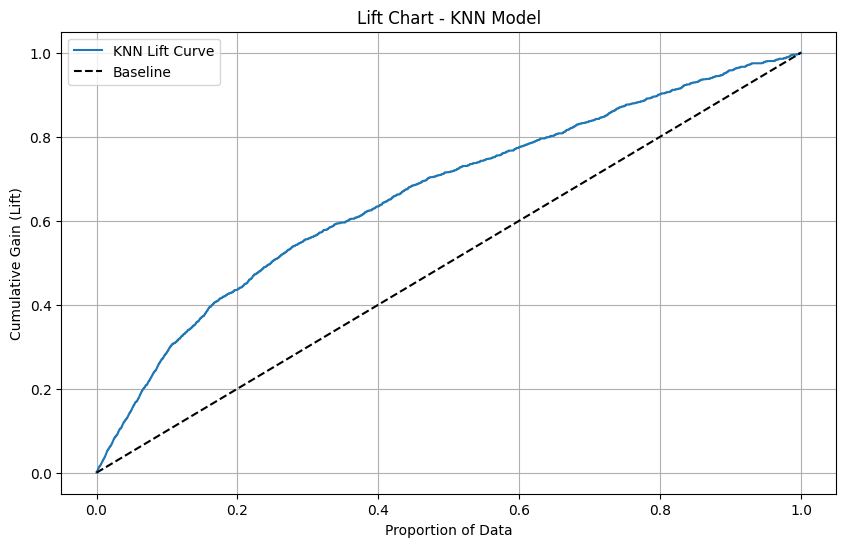

In [23]:
# KNN Model
y_pred_proba_knn = grid_search_knn.best_estimator_.predict_proba(X_test_scaled)[:, 1]  # KNN probabilities
plot_lift_chart(y_test, y_pred_proba_knn, 'KNN')


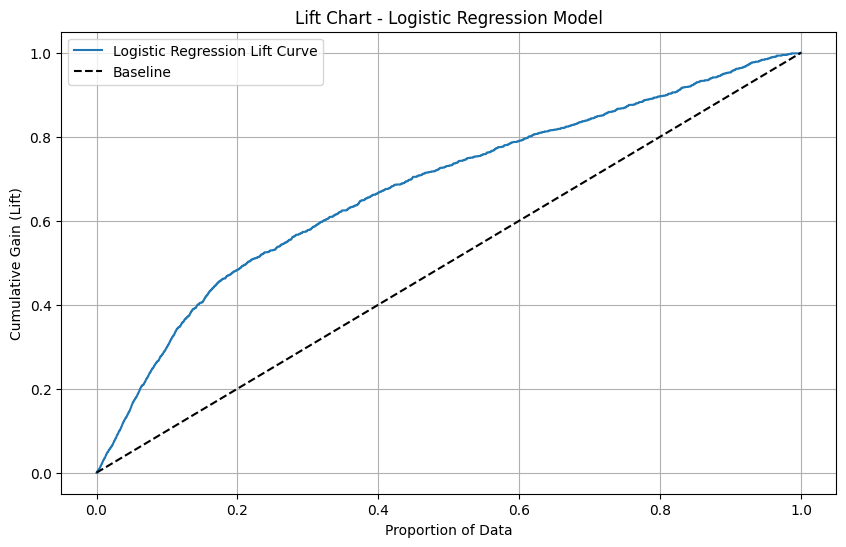

In [24]:

# Logistic Regression Model
y_pred_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]  # Logistic Regression probabilities
plot_lift_chart(y_test, y_pred_proba_logreg, 'Logistic Regression')



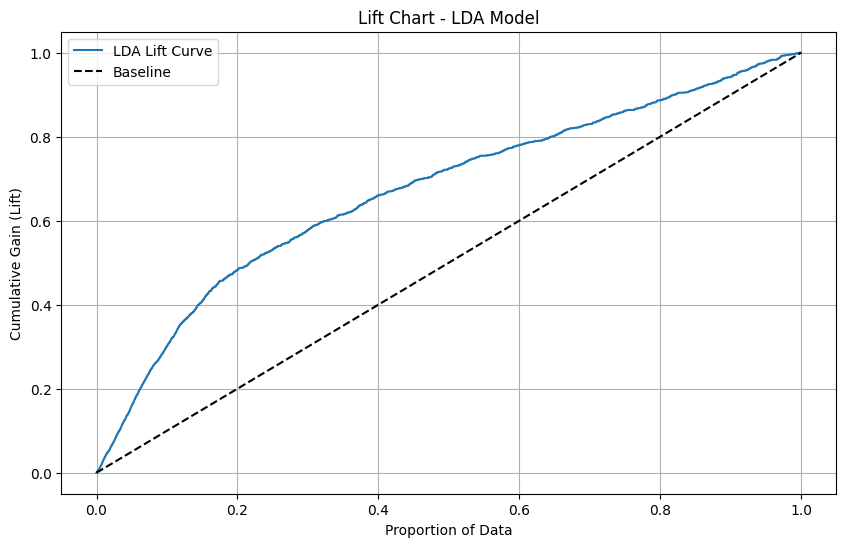

In [25]:
# LDA Model
y_pred_proba_lda = lda.predict_proba(X_test_scaled)[:, 1]  # LDA probabilities
plot_lift_chart(y_test, y_pred_proba_lda, 'LDA')



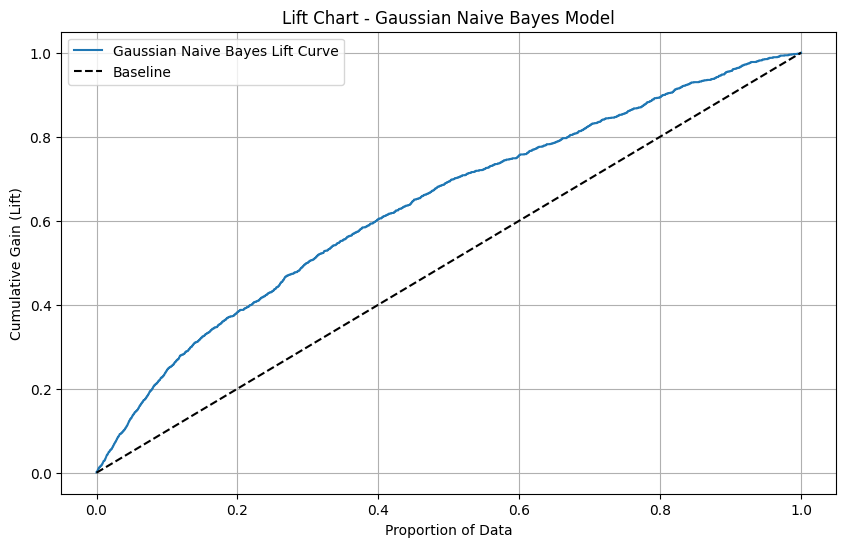

In [26]:
# Gaussian Naive Bayes Model
y_pred_proba_gnb = gnb.predict_proba(X_test)[:, 1]  # GNB probabilities
plot_lift_chart(y_test, y_pred_proba_gnb, 'Gaussian Naive Bayes')


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


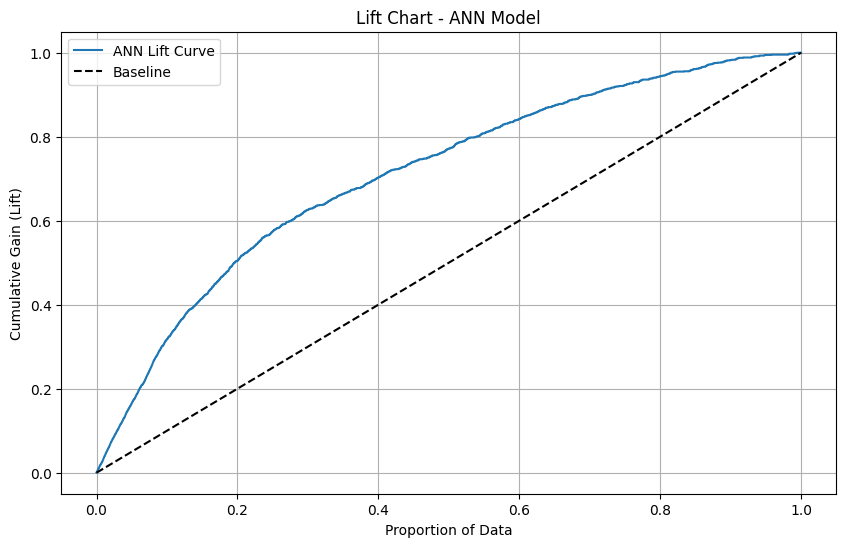

In [27]:
# ANN Model
y_pred_proba_ann = ann.predict(X_test_scaled).flatten()  # Ensure it's a 1D array
plot_lift_chart(y_test, y_pred_proba_ann, 'ANN')


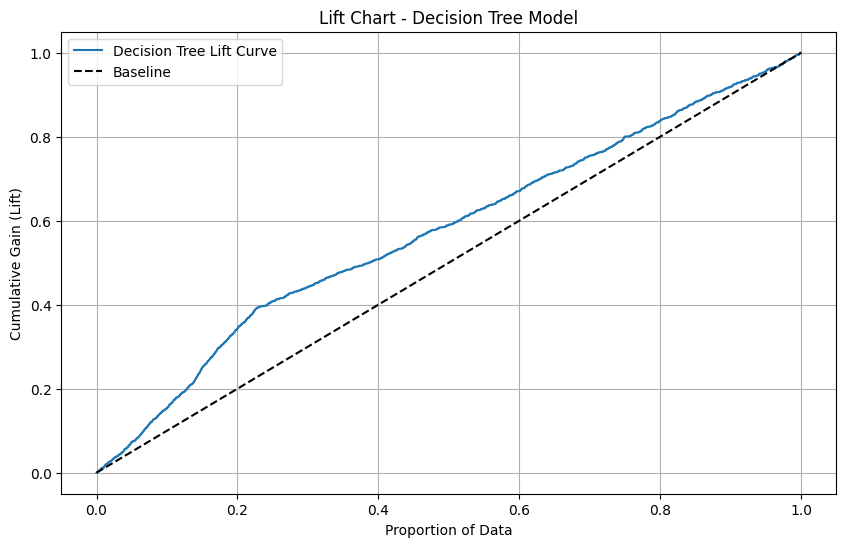

In [28]:

# Decision Tree Model
y_pred_proba_dtree = dtree.predict_proba(X_test)[:, 1]  # Decision Tree probabilities
plot_lift_chart(y_test, y_pred_proba_dtree, 'Decision Tree')

In [29]:
from sklearn.metrics import roc_auc_score

# Initialize a list to store results
results = []

# Function to calculate error rate and AUC
def calculate_metrics(model, X_train, y_train, X_val, y_val):
    # Predict on training set
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]  # Probabilities for AUC calculation
    train_error_rate = np.mean(y_train_pred != y_train)  # Calculate error rate

    # Calculate AUC for training set
    train_auc = roc_auc_score(y_train, y_train_pred_proba)

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for AUC calculation
    val_error_rate = np.mean(y_val_pred != y_val)  # Calculate error rate

    # Calculate AUC for validation set
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    return train_error_rate, train_auc, val_error_rate, val_auc

# KNN
train_error_knn, train_auc_knn, val_error_knn, val_auc_knn = calculate_metrics(best_knn, X_train_scaled, y_train, X_val_scaled, y_val)
results.append(['KNN', train_error_knn, train_auc_knn, val_error_knn, val_auc_knn])

# Logistic Regression
train_error_logreg, train_auc_logreg, val_error_logreg, val_auc_logreg = calculate_metrics(logreg, X_train_scaled, y_train, X_val_scaled, y_val)
results.append(['Logistic Regression', train_error_logreg, train_auc_logreg, val_error_logreg, val_auc_logreg])

# LDA
train_error_lda, train_auc_lda, val_error_lda, val_auc_lda = calculate_metrics(lda, X_train_scaled, y_train, X_val_scaled, y_val)
results.append(['LDA', train_error_lda, train_auc_lda, val_error_lda, val_auc_lda])

# Gaussian Naive Bayes
train_error_gnb, train_auc_gnb, val_error_gnb, val_auc_gnb = calculate_metrics(gnb, X_train, y_train, X_val, y_val)
results.append(['Gaussian Naive Bayes', train_error_gnb, train_auc_gnb, val_error_gnb, val_auc_gnb])

# ANN
train_error_ann = 1 - ann.evaluate(X_train_scaled, y_train, verbose=0)[1]  # 1 - accuracy
val_error_ann = 1 - ann.evaluate(X_val_scaled, y_val, verbose=0)[1]  # 1 - accuracy
y_train_pred_proba_ann = ann.predict(X_train_scaled).flatten()  # Probabilities for AUC calculation
train_auc_ann = roc_auc_score(y_train, y_train_pred_proba_ann)
y_val_pred_proba_ann = ann.predict(X_val_scaled).flatten()  # Probabilities for AUC calculation
val_auc_ann = roc_auc_score(y_val, y_val_pred_proba_ann)
results.append(['ANN', train_error_ann, train_auc_ann, val_error_ann, val_auc_ann])

# Decision Tree
train_error_dtree, train_auc_dtree, val_error_dtree, val_auc_dtree = calculate_metrics(dtree, X_train, y_train, X_val, y_val)
results.append(['Decision Tree', train_error_dtree, train_auc_dtree, val_error_dtree, val_auc_dtree])

# Convert results to a DataFrame for better visualization
import pandas as pd

results_df = pd.DataFrame(results, columns=['Model', 'Train Error Rate', 'Train AUC', 'Validation Error Rate', 'Validation AUC'])
print(results_df)


600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                  Model  Train Error Rate  Train AUC  Validation Error Rate  \
0                   KNN          0.171354   0.843628               0.195625   
1   Logistic Regression          0.303229   0.725285               0.301875   
2                   LDA          0.187292   0.719381               0.188542   
3  Gaussian Naive Bayes          0.624896   0.668542               0.619167   
4                   ANN          0.178854   0.790992               0.185417   
5         Decision Tree          0.000000   1.000000               0.276458   

   Validation AUC  
0        0.711153  
1        0.721337  
2        0.713105  
3        0.681868  
4        0.770908  
5        0.608787  


In [30]:


def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Neg', 'Predicted Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



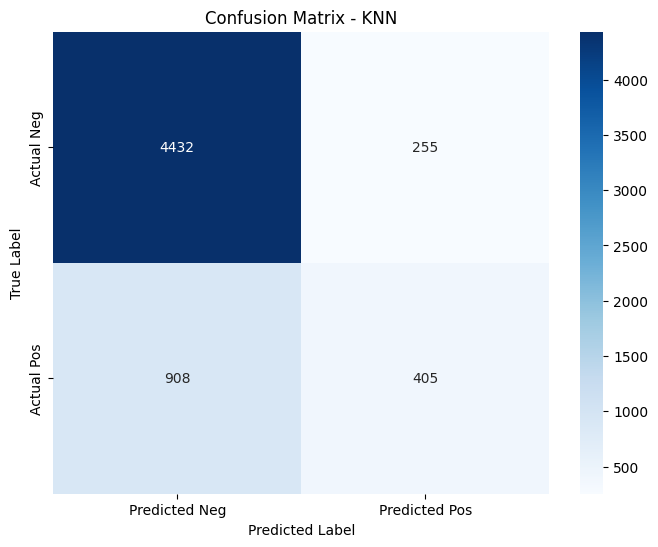

In [31]:
# Example for KNN
plot_confusion_matrix(y_test, y_pred_knn, 'KNN')

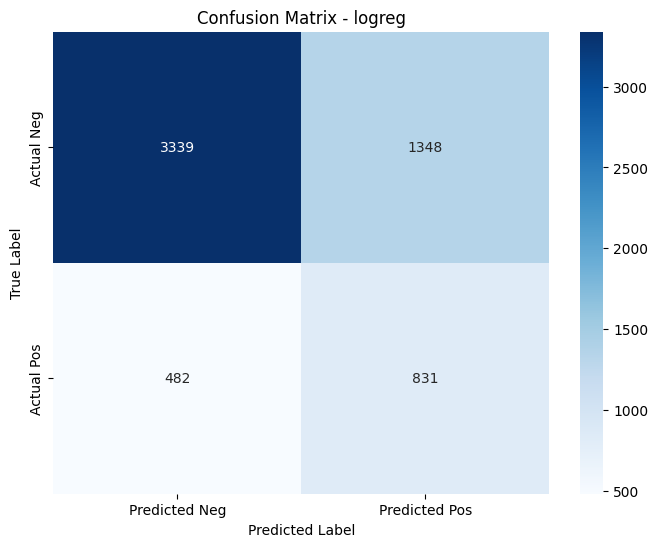

In [32]:
# Example for logreg
plot_confusion_matrix(y_test, y_pred_logreg, 'logreg')

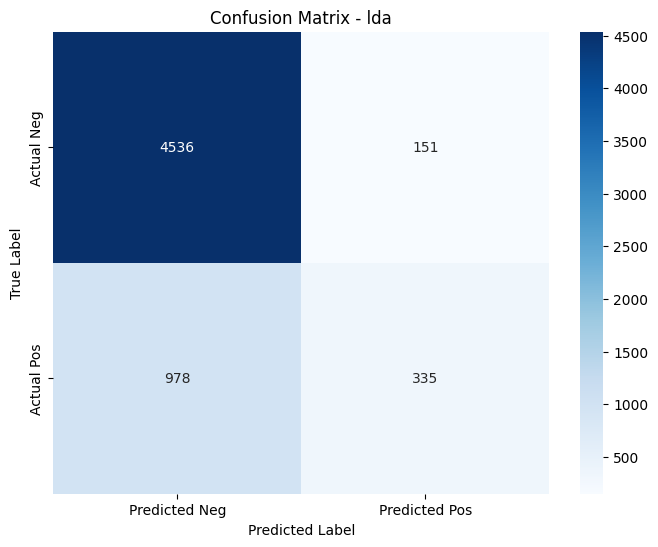

In [33]:
# Example for lda
plot_confusion_matrix(y_test, y_pred_lda, 'lda')

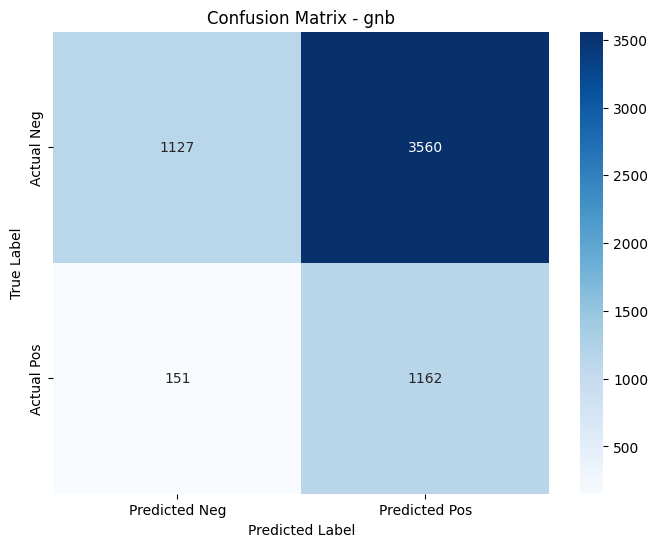

In [34]:
# Example for gnb
plot_confusion_matrix(y_test, y_pred_gnb, 'gnb')

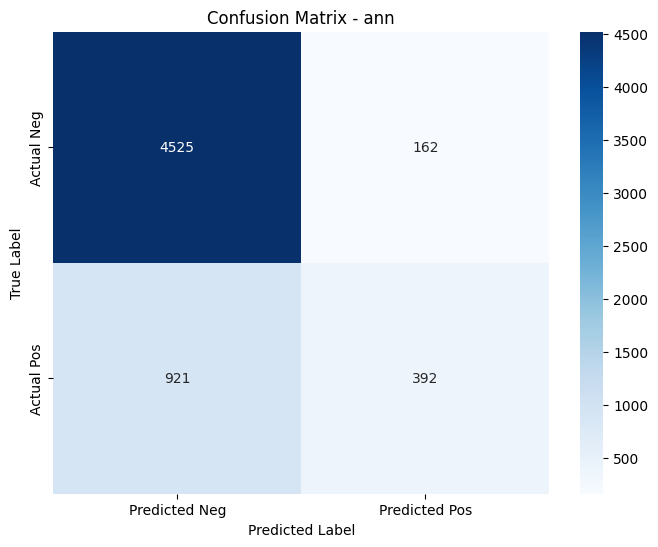

In [35]:
# Example for ann
plot_confusion_matrix(y_test, y_pred_ann, 'ann')

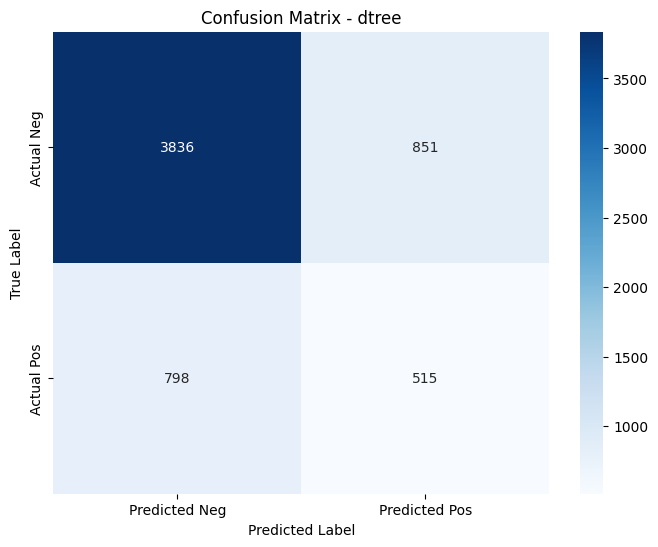

In [36]:
# Example for dtree
plot_confusion_matrix(y_test, y_pred_dtree, 'dtree')